In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/6888/project/tomatoAll.zip /content
!unzip /content/tomatoAll.zip

Streaming output truncated to the last 5000 lines.
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/253ddc99-8132-4710-bb89-eb83ab271abc___Matt.S_CG 0698.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25592188-309d-450c-b45f-fbbdb02b316f___Matt.S_CG 6181.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/2567c820-aa63-490c-8e47-921b85164728___Matt.S_CG 7447.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/256b92d9-41f3-47a4-870f-c0c0f0ac201e___Matt.S_CG 6842.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25b6cc2a-d883-4e3f-9caa-738e5ec35e30___JR_Sept.L.S 8465.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25c45a05-4f45-42ad-b18a-b7f694023a31___Matt.S_CG 0824.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25f7a39f-7fef-4f5d-af4f-cf21934f516a___JR_Sept.L.S 2493.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/261666dc-32fb-43b2-93

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator




base_path = '/content/tomatoAll/'
expert_path = '/content/tomatoAll/plan-diseases-expert'
village_path = '/content/tomatoAll/plant-village'


BATCH_SIZE = 128
IMG_SIZE = (256, 256)
SEED = 42

VALIDATION_SPLIT = 0.15

In [9]:
# Define the data augmentation configuration
augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT  # Set the validation split for the augmentation
)

# Apply the augmentation to the training generator
train_gen = augmentation.flow_from_directory(
    expert_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',  # Specify this is training data
    seed=SEED
)

# Validation generator without augmentation, just rescaling
validation_gen = ImageDataGenerator(validation_split=VALIDATION_SPLIT).flow_from_directory(
    expert_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  # Specify this is validation data
    seed=SEED
)

# Test generator for the village_path dataset without augmentation
test_gen = ImageDataGenerator().flow_from_directory(
    village_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 31841 images belonging to 9 classes.
Found 5614 images belonging to 9 classes.
Found 12803 images belonging to 9 classes.


In [3]:
train_gen, test_gen = tf.keras.utils.image_dataset_from_directory(
    expert_path,
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_gen.class_names
print(class_names)

VALIDATION_SPLIT = 0.15

train_gen = train_gen.take(int((1 - VALIDATION_SPLIT) * len(train_gen)))
valid_gen = train_gen.skip(int((1 - VALIDATION_SPLIT) * len(train_gen)))

test2_gen = tf.keras.utils.image_dataset_from_directory(
    village_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


test3_gen = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/tomato_images2/',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)
print(test3_gen.class_names)

# use cache to improve speed
#train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#valid_gen = valid_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#test_gen = test_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#test2_gen = test2_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 37455 files belonging to 9 classes.
Using 31837 files for training.
Using 5618 files for validation.
['Tomato Bacterial spot', 'Tomato Early blight', 'Tomato Late blight', 'Tomato Leaf Mold', 'Tomato Septoria leaf spot', 'Tomato Spider mites Two spotted spider mite', 'Tomato Target Spot', 'Tomato Tomato mosaic virus', 'Tomato healthy']
Found 12803 files belonging to 9 classes.
Found 16 files belonging to 9 classes.
['Tomato Bacterial spot', 'Tomato Early blight', 'Tomato Late blight', 'Tomato Leaf Mold', 'Tomato Septoria leaf spot', 'Tomato Spider mites Two spotted spider mite', 'Tomato Target Spot', 'Tomato Tomato mosaic virus', 'Tomato healthy']


In [40]:
import numpy as np
import tensorflow as tf

# Assuming your class names and generators are already defined as follows:
# class_names = train_gen.class_names
# train_gen, valid_gen, test_gen, test2_gen

def count_images_per_class(gen, class_names):
    class_counts = {class_name: 0 for class_name in class_names}

    for images, labels in gen.unbatch():  # Unbatch to iterate over individual samples
        # Count occurrences of each class
        print(labels)
        for label in labels:
            class_index = np.argmax(label)  # Assuming categorical labels
            class_counts[class_names[class_index]] += 1

    return class_counts

def print_class_counts(counts, name):
    print(f"{name} Class Counts:")
    for class_name, count in counts.items():
        print(f"  {class_name}: {count}")
    print("")

# Counting images per class in each generator
# train_class_counts = count_images_per_class(train_gen, class_names)
valid_class_counts = count_images_per_class(valid_gen, class_names)
# test_class_counts = count_images_per_class(test_gen, class_names)
# test2_class_counts = count_images_per_class(test2_gen, class_names)

# Resetting the generators
# train_gen.reset()
# valid_gen.reset()
# test_gen.reset()
# test2_gen.reset()

# Printing the counts
# print_class_counts(train_class_counts, "Train Generator")
print_class_counts(valid_class_counts, "Validation Generator")
# print_class_counts(test_class_counts, "Test Generator")
# print_class_counts(test2_class_counts, "Test2 Generator")


tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(9,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(9,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(9,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(9,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(9,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(9,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(9,), dtype=floa

In [39]:
import numpy as np
import tensorflow as tf

# Assuming your class names and generators are already defined as follows:
# class_names = train_gen.class_names
# train_gen, valid_gen, test_gen, test2_gen

def count_images_per_class(gen, class_names):
    class_counts = {class_name: 0 for class_name in class_names}

    for images, labels in gen.unbatch():  # Unbatch to iterate over individual samples
        # Count occurrences of each class
        for label in labels:
            print(label)
            class_index = np.argmax(label)  # Assuming categorical labels
            class_counts[class_names[class_index]] += 1

    return class_counts

def print_class_counts(counts, name):
    print(f"{name} Class Counts:")
    for class_name, count in counts.items():
        print(f"  {class_name}: {count}")
    print("")

# Counting images per class in each generator
# train_class_counts = count_images_per_class(train_gen, class_names)
# valid_class_counts = count_images_per_class(valid_gen, class_names)
test_class_counts = count_images_per_class(test_gen, class_names)
# test2_class_counts = count_images_per_class(test2_gen, class_names)

# Resetting the generators
# train_gen.reset()
# valid_gen.reset()
# test_gen.reset()
# test2_gen.reset()

# Printing the counts
# print_class_counts(train_class_counts, "Train Generator")
# print_class_counts(valid_class_counts, "Validation Generator")
print_class_counts(test_class_counts, "Test Generator")
# print_class_counts(test2_class_counts, "Test2 Generator")


Streaming output truncated to the last 5000 lines.
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtyp

In [34]:
import numpy as np
import tensorflow as tf

# Assuming your class names and generators are already defined as follows:
# class_names = train_gen.class_names
# train_gen, valid_gen, test_gen, test2_gen

def count_images_per_class(gen, class_names):
    class_counts = {class_name: 0 for class_name in class_names}

    for images, labels in gen.unbatch():  # Unbatch to iterate over individual samples
        # Count occurrences of each class
        for label in labels:
            class_index = np.argmax(label)  # Assuming categorical labels
            class_counts[class_names[class_index]] += 1

    return class_counts

def print_class_counts(counts, name):
    print(f"{name} Class Counts:")
    for class_name, count in counts.items():
        print(f"  {class_name}: {count}")
    print("")

# Counting images per class in each generator
train_class_counts = count_images_per_class(train_gen, class_names)
# valid_class_counts = count_images_per_class(valid_gen, class_names)
# test_class_counts = count_images_per_class(test_gen, class_names)
# test2_class_counts = count_images_per_class(test2_gen, class_names)

# Resetting the generators
# train_gen.reset()
# valid_gen.reset()
# test_gen.reset()
# test2_gen.reset()

# Printing the counts
print_class_counts(train_class_counts, "Train Generator")
# print_class_counts(valid_class_counts, "Validation Generator")
# print_class_counts(test_class_counts, "Test Generator")
# print_class_counts(test2_class_counts, "Test2 Generator")


Train Generator Class Counts:
  Tomato Bacterial spot: 243072
  Tomato Early blight: 0
  Tomato Late blight: 0
  Tomato Leaf Mold: 0
  Tomato Septoria leaf spot: 0
  Tomato Spider mites Two spotted spider mite: 0
  Tomato Target Spot: 0
  Tomato Tomato mosaic virus: 0
  Tomato healthy: 0



In [4]:
from tensorflow.keras.applications import ResNet101, InceptionV3, EfficientNetB1
from tensorflow.keras.applications import DenseNet121, DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
import time
import matplotlib.pyplot as plt

In [12]:
def create_and_train_model(base_model, train_gen, test_gen, model_filename, freeze_layers=True):

    # Freeze layers
    if freeze_layers:
      for layer in base_model.layers:
          layer.trainable = False

    # GlobalAveragePooling2D layer
    x = GlobalAveragePooling2D()(base_model.output)

    # Modify pre-trained model
    output = Dense(9, activation='softmax')(x)
    #model = Model(inputs=base_model.input, outputs=output)
    model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_10e_argu.model')


    # Compile
    #model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model for 50 epochs
    history = model.fit(train_gen, validation_data=valid_gen, epochs=10)

    # Save the model
    model.save(model_filename)

    # Plotting Loss
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Measure inference time
    start_time = time.time()
    _, accuracy = model.evaluate(test_gen)
    end_time = time.time()
    inference_time = end_time - start_time

    # Measure inference time 2
    start_time = time.time()
    _, accuracy2 = model.evaluate(test2_gen)
    end_time = time.time()
    inference_time2 = end_time - start_time

    # Get model size (number of parameters)
    num_params = model.count_params()

    return num_params, inference_time, accuracy, inference_time2, accuracy2


Epoch 1/50
53/53 [==============================] - 122s 441ms/step - loss: 0.3003 - accuracy: 0.9018 - val_loss: 16.4467 - val_accuracy: 0.2932
Epoch 2/50
53/53 [==============================] - 17s 316ms/step - loss: 0.0338 - accuracy: 0.9892 - val_loss: 4.2991 - val_accuracy: 0.5752
Epoch 3/50
53/53 [==============================] - 17s 315ms/step - loss: 0.0190 - accuracy: 0.9936 - val_loss: 0.7785 - val_accuracy: 0.8494
Epoch 4/50
53/53 [==============================] - 17s 315ms/step - loss: 0.0158 - accuracy: 0.9950 - val_loss: 1.0740 - val_accuracy: 0.8523
Epoch 5/50
53/53 [==============================] - 17s 315ms/step - loss: 0.0116 - accuracy: 0.9961 - val_loss: 0.1866 - val_accuracy: 0.9602
Epoch 6/50
53/53 [==============================] - 17s 316ms/step - loss: 0.0162 - accuracy: 0.9945 - val_loss: 0.4379 - val_accuracy: 0.9214
Epoch 7/50
53/53 [==============================] - 17s 315ms/step - loss: 0.0200 - accuracy: 0.9931 - val_loss: 1.0894 - val_accuracy: 0.84

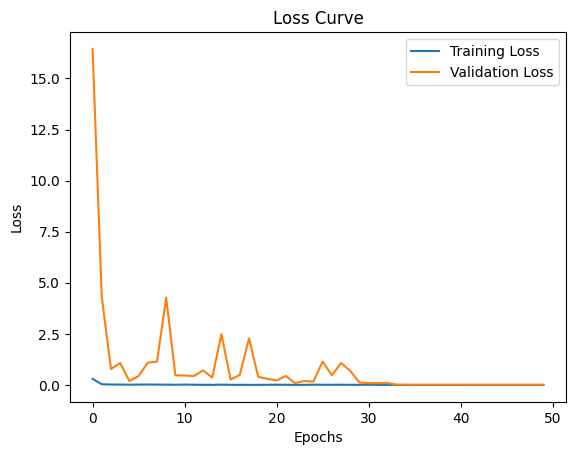

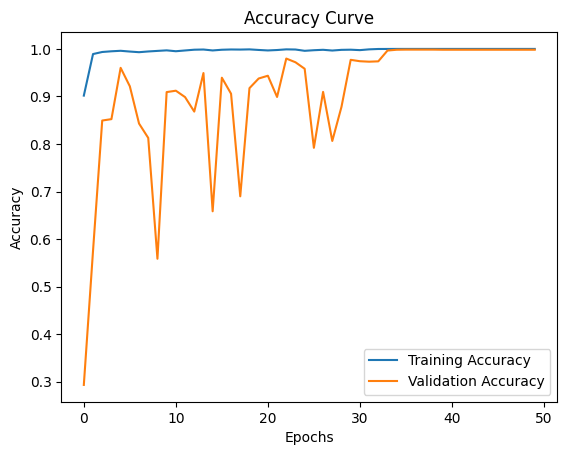

26/26 [==============================] - 4s 115ms/step - loss: 0.0047 - accuracy: 0.9987
DenseNet201: Params=18339273, Time=2.8846383094787598, Accuracy=0.9973300099372864, Time2=3.5271551609039307, Accuracy2=0.9986721873283386


In [ ]:
# Create and train DenseNet201 75 512
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, freeze_layers=False)
print(f"DenseNet201: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

74836368/74836368 [==============================] - 5s 0us/step
Epoch 1/50
211/211 [==============================] - 236s 538ms/step - loss: 0.1321 - accuracy: 0.9557 - val_loss: 5.4313 - val_accuracy: 0.5464
Epoch 2/50
211/211 [==============================] - 107s 507ms/step - loss: 0.0361 - accuracy: 0.9875 - val_loss: 0.1284 - val_accuracy: 0.9534
Epoch 3/50
211/211 [==============================] - 107s 507ms/step - loss: 0.0279 - accuracy: 0.9907 - val_loss: 0.0562 - val_accuracy: 0.9810
Epoch 4/50
211/211 [==============================] - 107s 507ms/step - loss: 0.0306 - accuracy: 0.9899 - val_loss: 0.3520 - val_accuracy: 0.9021
Epoch 5/50
211/211 [==============================] - 107s 507ms/step - loss: 0.0082 - accuracy: 0.9973 - val_loss: 0.0180 - val_accuracy: 0.9946
Epoch 6/50
211/211 [==============================] - 107s 507ms/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 1.0622 - val_accuracy: 0.7786
Epoch 7/50
211/211 [==============================] - 107s 

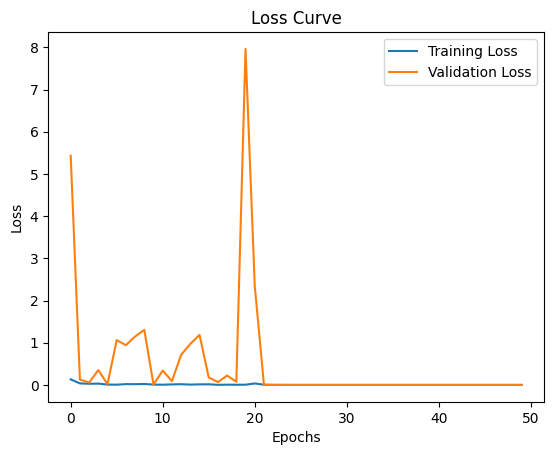

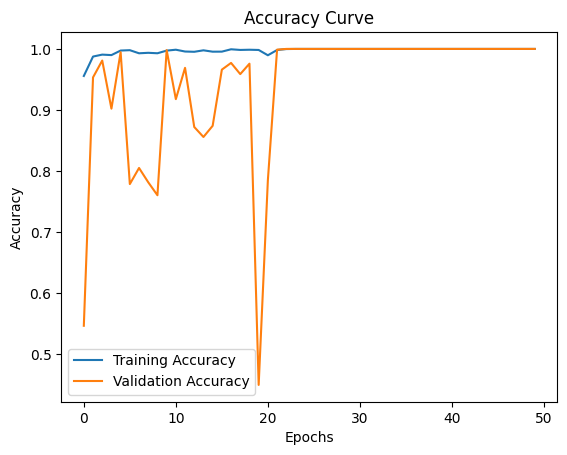

101/101 [==============================] - 17s 168ms/step - loss: 2.9107e-04 - accuracy: 0.9999
DenseNet201: Params=18339273, Time=7.660721302032471, Accuracy=0.9998220205307007, Time2=17.17328381538391, Accuracy2=0.9999219179153442


In [ ]:
# Create and train DenseNet201 256 128
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, freeze_layers=False)
print(f"DenseNet201: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

74836368/74836368 [==============================] - 4s 0us/step
Epoch 1/50
211/211 [==============================] - 230s 536ms/step - loss: 0.1375 - accuracy: 0.9563 - val_loss: 2.4905 - val_accuracy: 0.6211
Epoch 2/50
211/211 [==============================] - 107s 505ms/step - loss: 0.0427 - accuracy: 0.9857 - val_loss: 1.8691 - val_accuracy: 0.7468
Epoch 3/50
211/211 [==============================] - 107s 506ms/step - loss: 0.0255 - accuracy: 0.9914 - val_loss: 0.1274 - val_accuracy: 0.9614
Epoch 4/50
211/211 [==============================] - 107s 506ms/step - loss: 0.0184 - accuracy: 0.9944 - val_loss: 0.7356 - val_accuracy: 0.8196
Epoch 5/50
211/211 [==============================] - 107s 506ms/step - loss: 0.0303 - accuracy: 0.9897 - val_loss: 1.0831 - val_accuracy: 0.7834
Epoch 6/50
211/211 [==============================] - 107s 506ms/step - loss: 0.0106 - accuracy: 0.9960 - val_loss: 1.7943 - val_accuracy: 0.6592
Epoch 7/50
211/211 [==============================] - 107s 

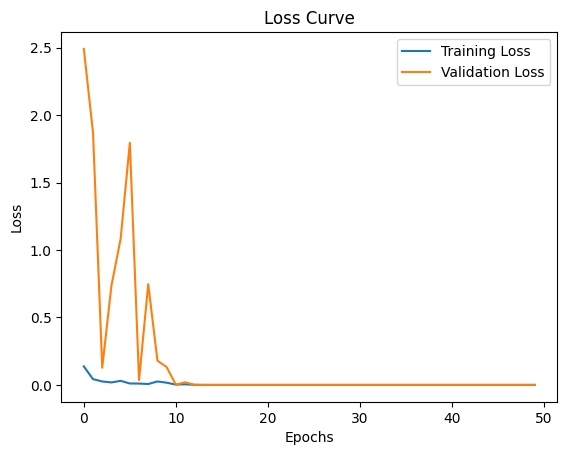

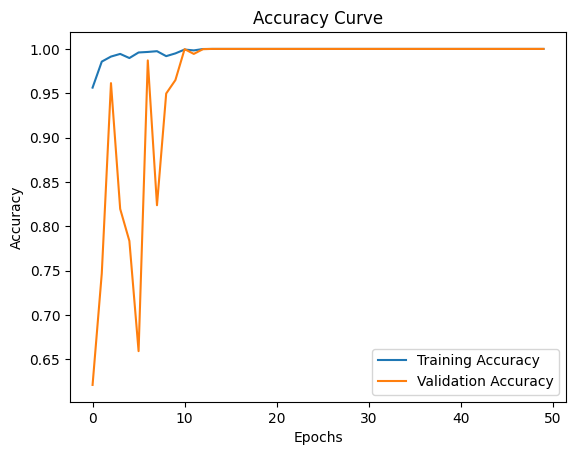

101/101 [==============================] - 17s 168ms/step - loss: 1.5831e-04 - accuracy: 0.9999
DenseNet201: Params=18339273, Time=7.696501016616821, Accuracy=0.9998220205307007, Time2=17.16569495201111, Accuracy2=0.9999219179153442


In [6]:
# Create and train DenseNet201 256 128 saved
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, '/content/drive/MyDrive/Colab Notebooks/densenet201_tomatoAll_256s_128b_50e.model', freeze_layers=False)
print(f"DenseNet201: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

Epoch 1/50
211/211 [==============================] - 39s 153ms/step - loss: 1.2793 - accuracy: 0.6115 - val_loss: 0.6835 - val_accuracy: 0.7725
Epoch 2/50
211/211 [==============================] - 31s 145ms/step - loss: 0.6033 - accuracy: 0.8036 - val_loss: 0.5179 - val_accuracy: 0.8333
Epoch 3/50
211/211 [==============================] - 31s 145ms/step - loss: 0.4866 - accuracy: 0.8426 - val_loss: 0.4307 - val_accuracy: 0.8594
Epoch 4/50
211/211 [==============================] - 31s 146ms/step - loss: 0.4265 - accuracy: 0.8615 - val_loss: 0.3811 - val_accuracy: 0.8809
Epoch 5/50
211/211 [==============================] - 31s 146ms/step - loss: 0.3834 - accuracy: 0.8779 - val_loss: 0.3766 - val_accuracy: 0.8748
Epoch 6/50
211/211 [==============================] - 31s 145ms/step - loss: 0.3595 - accuracy: 0.8842 - val_loss: 0.3539 - val_accuracy: 0.8811
Epoch 7/50
211/211 [==============================] - 31s 145ms/step - loss: 0.3350 - accuracy: 0.8917 - val_loss: 0.3071 - val_ac

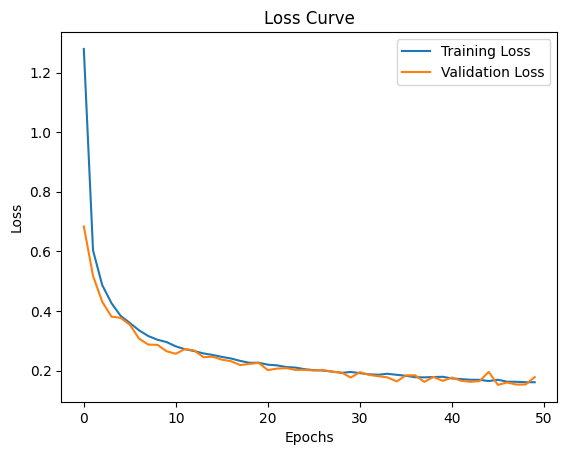

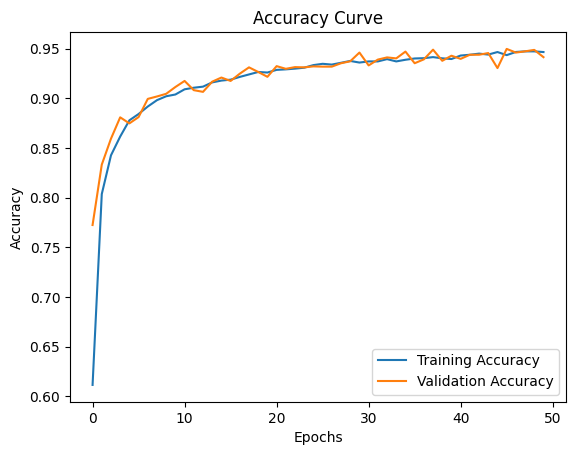

101/101 [==============================] - 12s 113ms/step - loss: 0.1824 - accuracy: 0.9381
DenseNet101: Params=7046729, Time=5.423450708389282, Accuracy=0.916874349117279, Time2=11.577496767044067, Accuracy2=0.9381394982337952


In [7]:
# Create and train DenseNet121 256 128 trainable=false  saved  50epoch
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_50e_ntrainable.model')
print(f"DenseNet101: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

Epoch 1/10
249/249 [==============================] - 567s 2s/step - loss: 0.1468 - accuracy: 0.9506 - val_loss: 1.4651 - val_accuracy: 0.7585
Epoch 2/10
249/249 [==============================] - 519s 2s/step - loss: 0.0540 - accuracy: 0.9826 - val_loss: 0.4319 - val_accuracy: 0.8804
Epoch 3/10
249/249 [==============================] - 517s 2s/step - loss: 0.0392 - accuracy: 0.9867 - val_loss: 0.2466 - val_accuracy: 0.9316
Epoch 4/10
249/249 [==============================] - 519s 2s/step - loss: 0.0286 - accuracy: 0.9902 - val_loss: 0.6040 - val_accuracy: 0.8806
Epoch 5/10
249/249 [==============================] - 517s 2s/step - loss: 0.0273 - accuracy: 0.9915 - val_loss: 0.5795 - val_accuracy: 0.8965
Epoch 6/10
249/249 [==============================] - 520s 2s/step - loss: 0.0209 - accuracy: 0.9931 - val_loss: 0.0648 - val_accuracy: 0.9802
Epoch 7/10
249/249 [==============================] - 517s 2s/step - loss: 0.0159 - accuracy: 0.9944 - val_loss: 0.0752 - val_accuracy: 0.9749

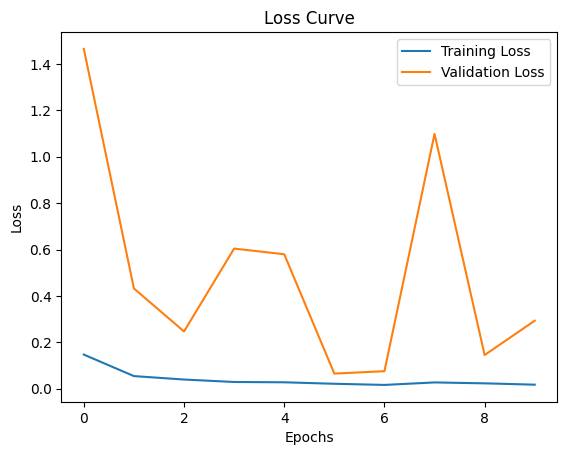

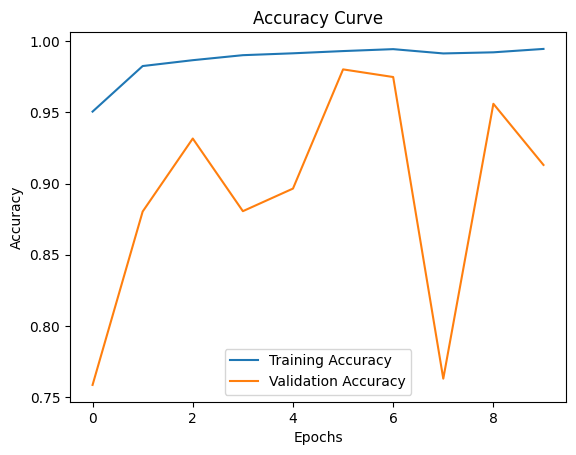

101/101 [==============================] - 12s 113ms/step - loss: 0.2041 - accuracy: 0.9378
DenseNet101: Params=7046729, Time=25.05459761619568, Accuracy=0.9037725329399109, Time2=11.551020860671997, Accuracy2=0.9378270506858826


In [11]:
# Create and train DenseNet121 256 128  saved  10epoch dataargu
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_10e_argu.model',freeze_layers=False)
print(f"DenseNet101: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

Epoch 1/10
249/249 [==============================] - 568s 2s/step - loss: 0.0278 - accuracy: 0.9908 - val_loss: 0.9410 - val_accuracy: 0.8440
Epoch 2/10
249/249 [==============================] - 520s 2s/step - loss: 0.0242 - accuracy: 0.9922 - val_loss: 0.2060 - val_accuracy: 0.9426
Epoch 3/10
249/249 [==============================] - 520s 2s/step - loss: 0.0187 - accuracy: 0.9935 - val_loss: 0.8982 - val_accuracy: 0.8521
Epoch 4/10
249/249 [==============================] - 522s 2s/step - loss: 0.0165 - accuracy: 0.9944 - val_loss: 0.9702 - val_accuracy: 0.8179
Epoch 5/10
249/249 [==============================] - 522s 2s/step - loss: 0.0165 - accuracy: 0.9947 - val_loss: 0.4977 - val_accuracy: 0.9121
Epoch 6/10
249/249 [==============================] - 523s 2s/step - loss: 0.0155 - accuracy: 0.9950 - val_loss: 0.3331 - val_accuracy: 0.9182
Epoch 7/10
249/249 [==============================] - 522s 2s/step - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0.1180 - val_accuracy: 0.9707

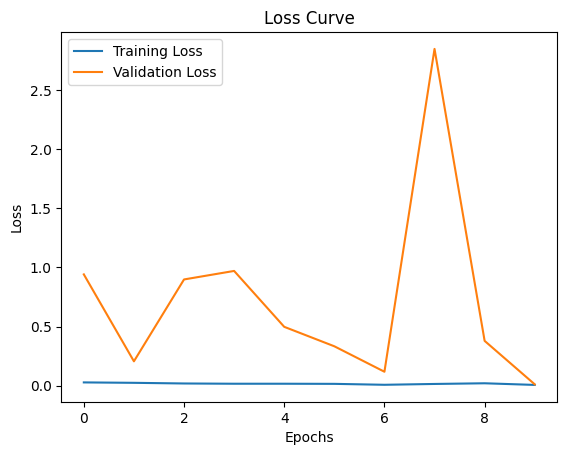

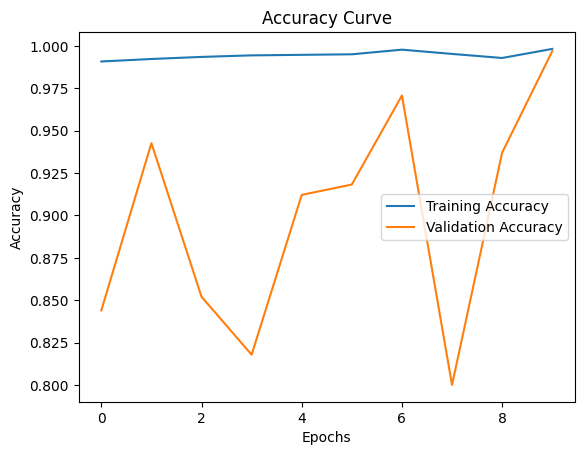

101/101 [==============================] - 12s 115ms/step - loss: 0.0283 - accuracy: 0.9928
DenseNet101: Params=7046729, Time=25.683151960372925, Accuracy=0.9980473518371582, Time2=11.766957759857178, Accuracy2=0.9928141832351685


In [13]:
# Create and train DenseNet121 256 128  saved  20epoch dataargu
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_20e_argu.model',freeze_layers=False)
print(f"DenseNet101: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

In [5]:
# prompt: load_model from the path

model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/densenet201_tomatoAll_256s_128b_50e.model')


44/44 [==============================] - 10s 222ms/step


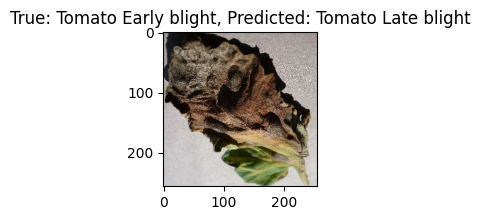

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all test images and their true labels
all_test_images = []
all_true_labels = []
for images, labels in test_gen:
    all_test_images.extend(images)
    all_true_labels.extend(np.argmax(labels, axis=1))

# Convert to numpy arrays for easier manipulation
all_test_images = np.array(all_test_images)
all_true_labels = np.array(all_true_labels)

# Predict labels for the test set
model.evaluate(test_gen)
predicted = model.predict(test_gen)
predicted_labels = np.argmax(predicted, axis=1)

# Ensure the arrays are of the same length
min_length = min(len(all_true_labels), len(predicted_labels))
all_true_labels = all_true_labels[:min_length]
predicted_labels = predicted_labels[:min_length]

# Find indices of misclassified images
misclassified_indices = np.where(predicted_labels != all_true_labels)[0]

# Plot a few misclassified images
num_images_to_show = 10  # Adjust as needed
for i in misclassified_indices[:num_images_to_show]:
    plt.figure(figsize=(2, 2))
    plt.imshow(all_test_images[i].astype("uint8"))
    true_label_name = class_names[all_true_labels[i]]
    predicted_label_name = class_names[predicted_labels[i]]
    plt.title(f"True: {true_label_name}, Predicted: {predicted_label_name}")
    plt.show()


101/101 [==============================] - 23s 227ms/step


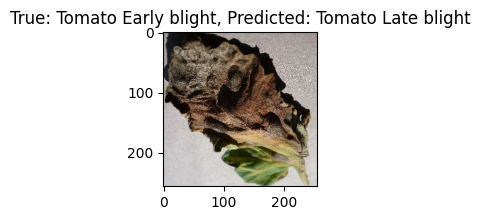

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all test images and their true labels
all_test_images = []
all_true_labels = []
for images, labels in test2_gen:
    all_test_images.extend(images)
    all_true_labels.extend(np.argmax(labels, axis=1))

# Convert to numpy arrays for easier manipulation
all_test_images = np.array(all_test_images)
all_true_labels = np.array(all_true_labels)

# Predict labels for the test set
predicted = model.predict(test2_gen)
predicted_labels = np.argmax(predicted, axis=1)

# Ensure the arrays are of the same length
min_length = min(len(all_true_labels), len(predicted_labels))
all_true_labels = all_true_labels[:min_length]
predicted_labels = predicted_labels[:min_length]

# Find indices of misclassified images
misclassified_indices = np.where(predicted_labels != all_true_labels)[0]

# Plot a few misclassified images
num_images_to_show = 10  # Adjust as needed
for i in misclassified_indices[:num_images_to_show]:
    plt.figure(figsize=(2, 2))
    plt.imshow(all_test_images[i].astype("uint8"))
    true_label_name = class_names[all_true_labels[i]]
    predicted_label_name = class_names[predicted_labels[i]]
    plt.title(f"True: {true_label_name}, Predicted: {predicted_label_name}")
    plt.show()


tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(16, 9), dtype=float32)
1/1 [==============================] - 0s 103ms/step
[0 0 1 2 3 0 2 3 4 5 6 7 8 8 8 2]


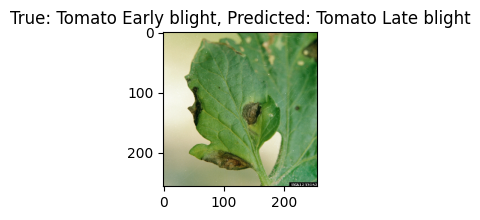

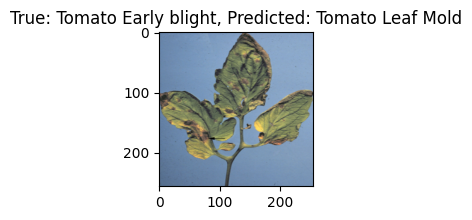

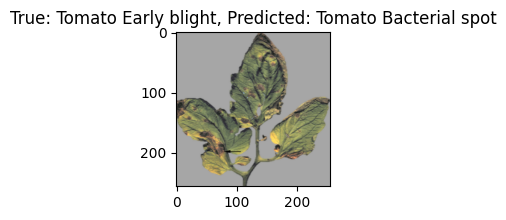

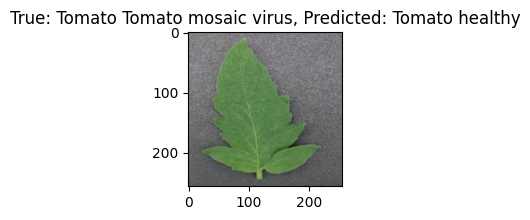

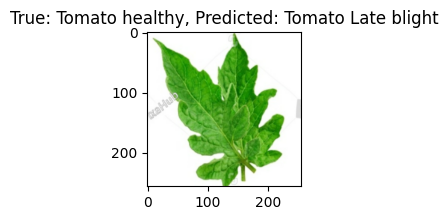

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all test images and their true labels
all_test_images = []
all_true_labels = []
for images, labels in test3_gen:
    all_test_images.extend(images)
    print(labels)
    all_true_labels.extend(np.argmax(labels, axis=1))

# Convert to numpy arrays for easier manipulation
all_test_images = np.array(all_test_images)
all_true_labels = np.array(all_true_labels)

# Predict labels for the test set
model.evaluate(test3_gen)
predicted = model.predict(test3_gen)
predicted_labels = np.argmax(predicted, axis=1)

# Ensure the arrays are of the same length
min_length = min(len(all_true_labels), len(predicted_labels))
all_true_labels = all_true_labels[:min_length]
predicted_labels = predicted_labels[:min_length]

print(predicted_labels)

# Find indices of misclassified images
misclassified_indices = np.where(predicted_labels != all_true_labels)[0]

# Plot a few misclassified images
num_images_to_show = 10  # Adjust as needed
for i in misclassified_indices[:num_images_to_show]:
    plt.figure(figsize=(2, 2))
    plt.imshow(all_test_images[i].astype("uint8"))
    true_label_name = class_names[all_true_labels[i]]
    predicted_label_name = class_names[predicted_labels[i]]
    plt.title(f"True: {true_label_name}, Predicted: {predicted_label_name}")
    plt.show()


1/1 [==============================] - 0s 41ms/step


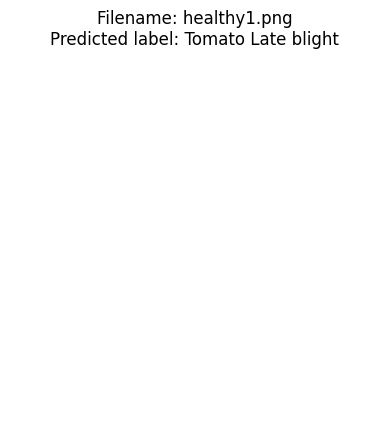

1/1 [==============================] - 0s 44ms/step


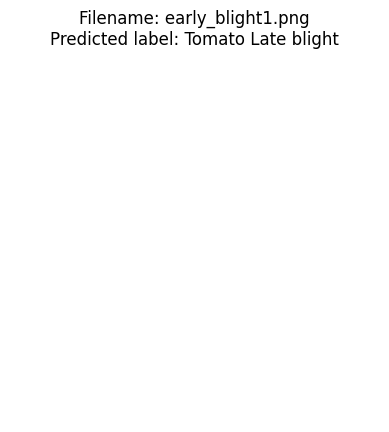

1/1 [==============================] - 0s 44ms/step


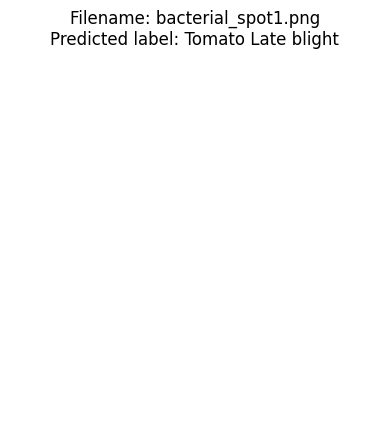

1/1 [==============================] - 0s 39ms/step


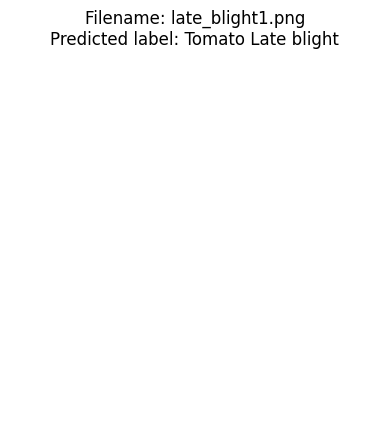

1/1 [==============================] - 0s 39ms/step


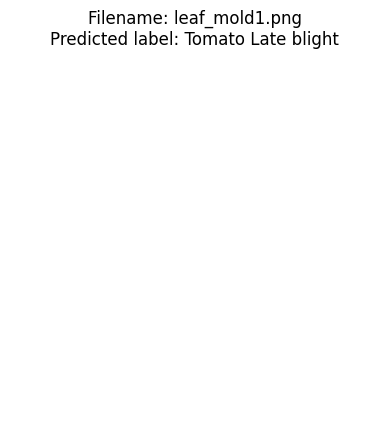

1/1 [==============================] - 0s 39ms/step


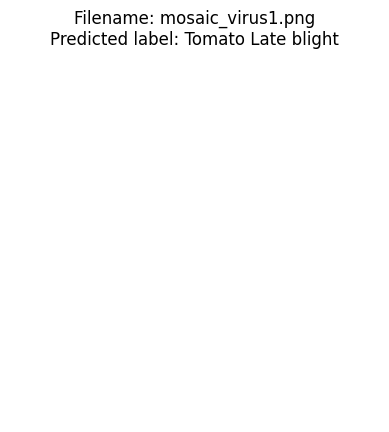

1/1 [==============================] - 0s 40ms/step


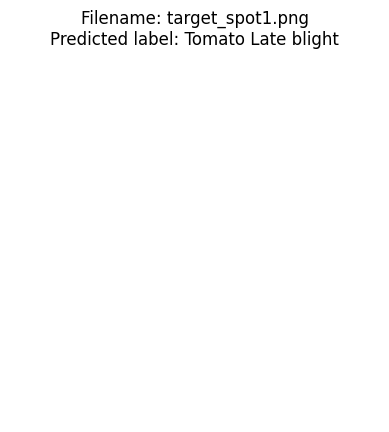

1/1 [==============================] - 0s 41ms/step


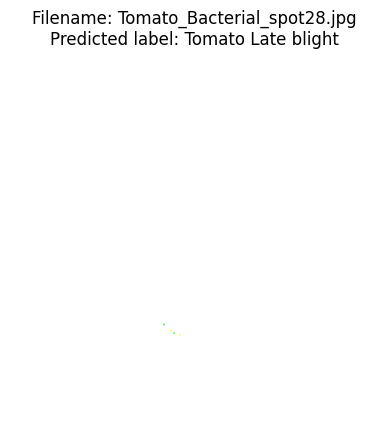

In [43]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# Function to crop and resize an image
def crop_and_resize_image(image_path, target_size):
    # Load image
    img = image.load_img(image_path, target_size=target_size)
    # Convert to array and preprocess
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Use appropriate preprocessing function
    return image.img_to_array(img), img_array


# Directory containing images
image_dir = '/content/drive/MyDrive/Colab Notebooks/tomato_images/'

# List all image files in the directory
image_paths = glob.glob(os.path.join(image_dir, '*.*'))  # Adjust pattern as needed

# Process and predict each image
for image_path in image_paths:
    # Prepare the image
    img, processed_image = crop_and_resize_image(image_path, target_size=(256, 256))

    # Predict
    prediction = model.predict(processed_image)

    # Convert prediction to class name
    predicted_class = class_names[np.argmax(prediction)]

    # Extract filename from the path
    filename = os.path.basename(image_path)

    # Display the image
    plt.imshow(img)
    plt.title(f"Filename: {filename}\nPredicted label: {predicted_class}")
    plt.axis('off')
    plt.show()
